In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Initial data preparation

In [4]:
df = pd.read_csv('Data/data_car_price.csv')

display(df.head(3))
printest('total cars (rows)', len(df))

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


total cars (rows) : 
 11914 



This dataset overview reveals some inconsistencies, such as column names containing spaces or underscores ( _ ), and varying capitalization and spacing within feature values. To address these issues and enhance clarity, we can normalize the data by replacing all spaces with underscores and converting all letters to lowercase.

In [5]:
# Columns

# .str transform each element into string
# .str != String()
df_columns_lower = df.columns.str.lower()
df.columns  = df_columns_lower.str.replace(' ', '_')

# Rows

# boolean mask
mask = df.dtypes == 'object'
# keep the values in witch mask = True
filter = df.dtypes[mask].index
string_columns = list(filter)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(3)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350


This dataset contains multiple columns (features):

- **make**: The car's brand (e.g., BMW, Toyota, etc.)
- **model**: The car's specific model
- **year**: The manufacturing year of the car
- **engine_fuel_type**: The type of fuel required by the engine (e.g., diesel, electric, etc.)
- **engine_hp**: The engine's horsepower
- **engine_cylinders**: The number of engine cylinders
- **transmission_type**: The type of transmission (automatic or manual)
- **driven_wheels**: Front, rear, or all-wheel drive
- **number_of_doors**: The number of doors in the car
- **market_category**: Market segment (e.g., luxury, crossover, etc.)
- **vehicle_size**: The size classification (compact, midsize, or large)
- **vehicle_style**: The body style (e.g., sedan or convertible)
- **highway_mpg**: Fuel efficiency on the highway (measured in miles per gallon)
- **city_mpg**: Fuel efficiency in the city (measured in miles per gallon)
- **popularity**: The number of times the car was mentioned in a Twitter stream
- **msrp**: The manufacturer's suggested retail price

Our primary focus in this dataset is the **MSRP** column, which represents the car's price. We will use this column to predict car prices.

# Exploratory Data Analysis (EDA)

The MSRP column holds crucial data, as it represents our target variable, the 'y', which is the value we aim to predict accurately.

A vital initial step in exploratory data analysis is examining the distribution of 'y'. By doing so, we gain insight into the possible values of 'y' and their frequency of occurrence. This visualization is commonly referred to as a histogram, which effectively conveys the distribution of our target variable.

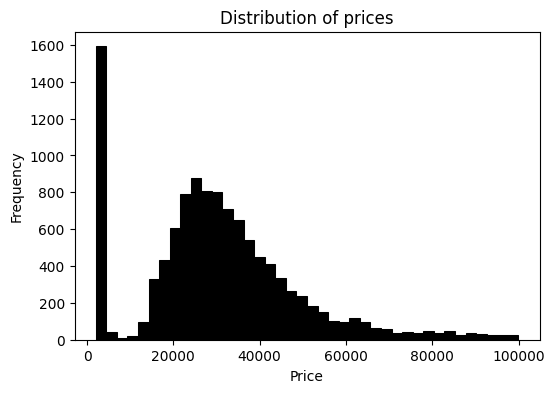

In [6]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp[df.msrp < 1e5], bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

By taking a closer look at values below $10^5$, we can observe the distribution more closely. There are numerous cars with lower prices on the left side of the histogram, but the count drops off rapidly, leaving a long tail of cars with high prices. This long-tail distribution is a common occurrence in situations where many items have low prices, while only a few are expensive.

Visualizing the long-tail distribution can be challenging due to the extreme values that make it difficult to discern the shape of the distribution. Training a model on this type of data can also be problematic, as the distribution may cause confusion for the model, hindering its ability to learn the important features effectively.

To solve this problem we can make a transformation in the values by applying a log function. The log function has a nice property of transforming large values into smaller ones while maintaining the relative differences between the original values. This transformation can help make skewed distributions more manageable for visualization and analysis. Consider the following transformation:

$$y_{new} = log(x+1)$$

the $+1$ part is important in cases that have zeros.

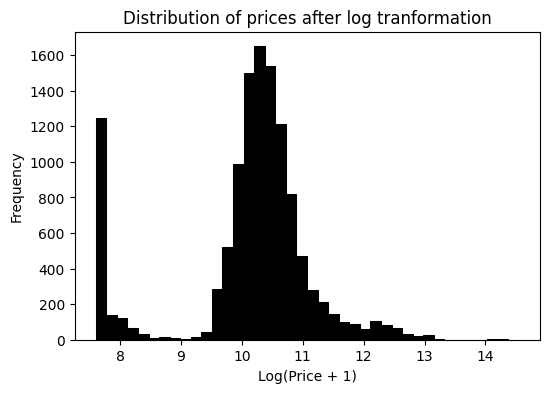

In [7]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [8]:
# Checking for missing values (NaN) at other features

df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

A few columns have missing values. Market_category is the most affected one, in which we have
almost 4,000 rows with missing values.

# Data Validation

In [9]:
n = len(df)
n_val = int(0.2*n)   # 20% for validation
n_test = int(0.2*n)  # 20% for test
n_train = int(0.6*n) # 60% for train

# shuffle indices
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)
# subset rows by indices
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# original values from the target
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

# apply the log transformation in original values
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# To avoid accidentally using the target variable
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']


# Linear Regression

Consider a hypothetical dataset with multiple features $X_{1},\cdots, X_{d}$ and a target variable $Y$ as shown:

$$
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & Y\\
\hline
x_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
x_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

Here, each row vector $ \mathbf{x}_i = (1, x_{i1}, \ldots, x_{id}) $ represents an instance of the dataset with $ d+1 $ values. The first column, $ X_0 $, is the intercept term and is set to 1 for all instances. The dataset is separated in a feature matrix $\mathbf{X}$ and a target vector $\mathbf{Y}$:


$$\mathbf{X}=
\left( \begin{array}{cccc}
 1& x_{11}& \cdots&x_{1d} \\
\vdots&\vdots&\ddots&\vdots&\\
1&x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~ 

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$




The linear regression model for multiple features $ X_1, \ldots, X_d $ can be represented as:


$$\mathbf{\hat{Y}} = \mathbf{X}\mathbf{w} $$

Here, $\mathbf{w} = (w_0, \ldots, w_d)^T$ denotes the column vector of weights that the model seeks to learn for optimal regression. $\mathbf{\hat{Y}}$ represents the predicted values, and $\mathbf{Y}$ stands for the true values (or target values). The error function commonly used is the sum of squared errors (SSE):

$$\text{SSE} = \sum_{i}^{n} ||{\epsilon}_i||^2 = \mathbf{\epsilon}\mathbf{\epsilon}^T$$

where $\mathbf{\epsilon} = \mathbf{\hat{Y}} - \mathbf{Y}$.

Rearranging the error function gives:

$$
\begin{align*}
\text{SSE} &= (\mathbf{\hat{Y}} - \mathbf{Y})^T(\mathbf{\hat{Y}} - \mathbf{Y})\\
&=\mathbf{Y}^T \mathbf{Y}  - 2\mathbf{Y}^T \mathbf{\hat{Y}} + \mathbf{\hat{Y}}^T \mathbf{\hat{Y}}\\
&=\mathbf{Y}^T \mathbf{Y}  - 2\mathbf{Y}^T  (\mathbf{X}\mathbf{w}) + ( \mathbf{X}\mathbf{w})^T ( \mathbf{X}\mathbf{w})\\
&=\mathbf{Y}^T \mathbf{Y}  - 2 \mathbf{w}^T (\mathbf{X}^T\mathbf{Y}) + \mathbf{w}^T( \mathbf{X}^T\mathbf{X}) \mathbf{w}
\end{align*}
$$

The goal is to minimize this error to optimize the ideal weights. Instead of using gradient descent, we take the derivative of the SSE with respect to the weights, set it equal to zero, and find a local minimum of the SSE function. This leads to the following optimal weights for the optimization problem:

$$
\begin{align*}
\frac{\partial (\text{SSE})}{\partial \mathbf{w}} & = -2\mathbf{X}^T\mathbf{Y} + (\mathbf{X}^T\mathbf{X})\mathbf{w} + \mathbf{w}^T(\mathbf{X}^T\mathbf{X})\\
& = -2\mathbf{X}^T\mathbf{Y} + 2(\mathbf{X}^T\mathbf{X})\mathbf{w} = 0
\end{align*}
$$

Solving for the optimal weights, we get the following analytical solution:

$$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}$$

In summary, for a given dataset with multiple features, we can represent the linear regression model as a product of weights and input features. The objective is to minimize the sum of squared errors (SSE) to find the optimal weights for the model. By taking the derivative of the SSE with respect to the weights and setting it to zero, we can determine the optimal weights for the optimization problem using the above equation. This concept can be translated into Python code as follows:

In [10]:
def linear_regression(X, y):
    # adding ones in the dataset X
    X_0 = np.ones(X.shape[0])
    X = np.column_stack([X_0, X])


    XTX = X.T.dot(X)
    XTX_inverse = np.linalg.inv(XTX)
    w = XTX_inverse.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Baseline solution

We will start with a simple method by selecting a few numerical features and constructing the matrix $X$ using these features. Additionally, we will handle missing values by filling them with a substitute value. The most basic approach is to fill the missing values with zeros. Although this may not the best way to deal with missing values, but it is often sufficient. By setting the missing feature value to zero, the respective feature is effectively ignored.

In [11]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

def prepare_X(df):
    # select numerical columns
    df_num = df[base]
    # nan to zeros
    df_num = df_num.fillna(0)
    # return only features array
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

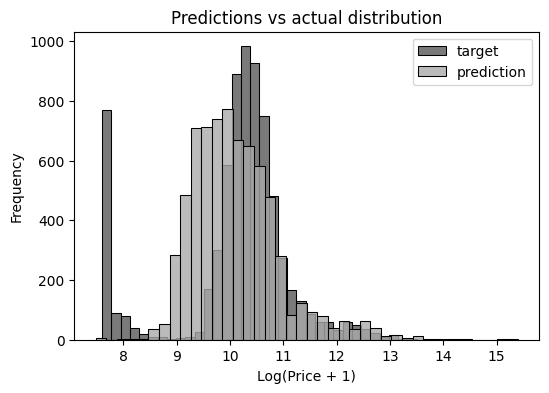

In [12]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

From the plot, we observe that the distribution of predicted values significantly differs from the actual values. This outcome suggests that the model might not be sufficiently robust to capture the target variable's distribution.

Lets calculate the error function. A lower SSE value indicates a better fit of the model to the data.Also SSE is sensitive to the scale of the target variable, so it may be more informative to use a normalized metric such as mean squared error (MSE) or root mean squared error (RMSE) for comparison purposes.

let's compare each one and see in pratics the results:

In [13]:
def mse_sse_rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    sse = np.sum(error ** 2)
    rmse = np.sqrt(mse)
    return mse, sse, rmse

# for training set
mse, sse, rmse  = mse_sse_rmse(y_train, y_pred)
print("Train Dataset")
printest('mse:', mse )
printest('sse:', sse)
printest('rmse:', rmse)

Train Dataset
mse: : 
 0.5707185661356206 

sse: : 
 4079.496310737416 

rmse: : 
 0.7554591756909307 



In [14]:
# for validation set
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
mse, sse, rmse = mse_sse_rmse(y_val, y_pred)
print("\nValidation Dataset")
printest('mse:', mse )
printest('sse:', sse)
printest('rmse:', rmse)


Validation Dataset
mse: : 
 0.5803845734290475 

sse: : 
 1382.4760539079912 

rmse: : 
 0.7618297535729669 



The difference in the magnitude of these error metrics is because MSE and RMSE are average values, whereas SSE is the sum of all squared errors. The larger the dataset, the larger the SSE will be in comparison to the MSE and RMSE.

# Simple feature engineering

## Handling numerical variables

In [15]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
def prepare_X(df):
    
    # create copy of input
    df = df.copy()
    features = base.copy()

    # the dataset was created in 2017
    df['age'] = 2017 - df['year']
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    x = df_num.values
    return x

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    rmse = np.sqrt(mse)
    return rmse

In [16]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
printest('rmse for train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
printest('rmse for validation', rmse(y_val, y_pred))

rmse for train : 
 0.5175461085504556 

rmse for validation : 
 0.5171097946609381 



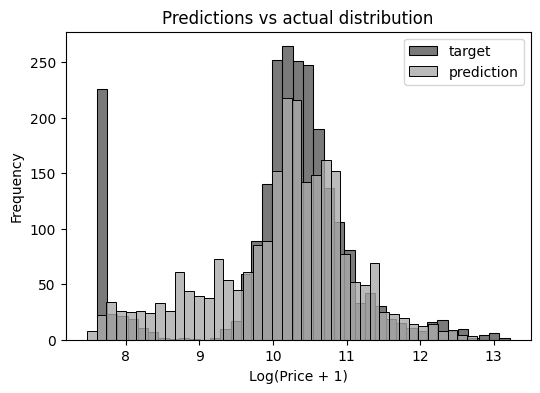

In [17]:
plt.figure(figsize=(6, 4))


sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

The validation error has improved to 0.517, which is a significant reduction from the previous value of 0.76. This demonstrates that incorporating the "age" attribute has indeed enhanced our predictions. Additionally, the distribution of predicted values now follows more closely the target distribution. This improvement is further confirmed by the updated validation RMSE score.

## Handling categorical variables


Handling categorical data involves converting the categorical variables into a form that can be easily understood and processed by machine learning algorithms. One common method to achieve this is one-hot encoding, which creates binary features for each distinct category.

To extract the possible set of values for each categorical column, we proceed as follows:

In [18]:
print(df['make'].value_counts().head(6), "\n")

# cars banding with less then 600 will not be capture for the model
printest("Above 600:", df['make'].value_counts()[df['make'].value_counts() > 600].index.values)

make
chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
nissan         558
Name: count, dtype: int64 

Above 600: : 
 ['chevrolet' 'ford' 'volkswagen' 'toyota' 'dodge'] 



In [19]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [20]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
printest('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
printest('validation:', rmse(y_val, y_pred))

train: : 
 0.505930401897355 

validation: : 
 0.5074572881971692 



The previous value was 0.517, so we managed to improve the RMSE score further. We can use one more variables like engine_fuel_type:

In [21]:
print(df['engine_fuel_type'].value_counts().head(6), "\n")

# cars banding with less then 600 will not be capture for the model
printest("Above 899:", df['engine_fuel_type'].value_counts()[df['engine_fuel_type'].value_counts() > 890].index.values)

engine_fuel_type
regular_unleaded                  7172
premium_unleaded_(required)       2009
premium_unleaded_(recommended)    1523
flex-fuel_(unleaded/e85)           899
diesel                             154
electric                            66
Name: count, dtype: int64 

Above 899: : 
 ['regular_unleaded' 'premium_unleaded_(required)'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)'] 



In [22]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [23]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
printest('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
printest('validation:', rmse(y_val, y_pred))

train: : 
 0.47890349256044024 

validation: : 
 0.4747016023882818 



Lets now add the following columns too:

- transmission_type 
- driven_wheels 
- market_category 
- vehicle_size
- vehicle_style

In [24]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [25]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
printest('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
printest('validation:', rmse(y_val, y_pred))

train: : 
 449.9966997402268 

validation: : 
 291.8247878955515 




The observed value is noticeably worse than before. Contrary to our expectations, the introduction of new features has actually deteriorated the model's performance. We need to examine the underlying causes for this decline in the model's accuracy.

# Regularization

## Ridge Regression ($L_2$)

Adding new features does not always help, and in our case, it made things a lot worse. The reason for this behavior is numerical instability and the presence of highly correlated features. When we introduce new columns to $X$, these columns might be highly correlated with existing columns, leading to interdependence among the predictor variables. This can result in the column vectors becoming linearly dependent or nearly linearly dependent, causing the matrix $(\mathbf{X}^T\mathbf{X})$ to be ill-conditioned (close to singular) or singular (non-invertible).

If two or more columns of a matrix are not orthogonal to each other (i.e., they are correlated), it implies that the matrix is not invertible. Consequently, the optimal weights equation:

$$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}$$

becomes problematic, as the inverse matrix $(\mathbf{X}^T\mathbf{X})$ is either hard to compute accurately or non-existent. This can result in large or unstable estimates of the regression coefficients, which can lead to poor model performance.

Regularization aims to ensure the existence of the inverse by forcing the matrix to be invertible, controlling the weights of the model so that they behave correctly and do not become too large.

Instead of merely minimizing the squared residual error $||\mathbf{Y} - \mathbf{\hat{Y}}||^2$, we add a regularization term involving the squared norm of the weights vector $|| \mathbf{w} ||^2$:

$$L(\mathbf{w}) = ||\mathbf{Y} - \mathbf{\hat{Y}}||^2 + \alpha || \mathbf{w} ||^2$$

The goal is to minimize $L(\mathbf{w})$. To achieve this, we take the derivative of $L(\mathbf{w})$ with respect to the weights, set it equal to zero, and find a local minimum of the function. This results in the following optimal weights:

$$\frac{dL(\mathbf{w})}{d\mathbf{w}} = -2\mathbf{X}^T\mathbf{Y} + 2(\mathbf{X}^T\mathbf{X})\mathbf{w} +2 \alpha \mathbf{w}= 0$$

therefore, the optimal solution is

$$\mathbf{w} = (\mathbf{X}^T\mathbf{X}+ \alpha \mathbf{I})^{-1}\mathbf{X}^T\mathbf{Y}$$

where $\mathbf{I}$ is the identity matrix. The matrix $(\mathbf{X}^T\mathbf{X}+ \alpha \mathbf{I})$ is always invertible for $\alpha > 0$. 

The reason behind this is that $\mathbf{X}^T\mathbf{X}$ is always symmetric and positive semi-definite, meaning all its eigenvalues are non-negative. However, this does not guarantee invertibility, as eigenvalues can still be zero, resulting in a singular matrix.

When adding the two matrices, $(\mathbf{X}^T\mathbf{X} + \alpha \mathbf{I})$, the resulting matrix's eigenvalues are the sums of the corresponding eigenvalues of the original matrices. Since the eigenvalues of $\mathbf{X}^T\mathbf{X}$ are non-negative and those of $\alpha \mathbf{I}$ are positive, the eigenvalues of $(\mathbf{X}^T\mathbf{X} + \alpha \mathbf{I})$ are strictly positive. A symmetric matrix with strictly positive eigenvalues is positive definite, which are always invertible as none of their eigenvalues are equal to zero. Consequently, the matrix $(\mathbf{X}^T\mathbf{X} + \alpha \mathbf{I})$ is always invertible for $\alpha > 0$.

This concept can be translated into Python code as follows:

In [26]:
def ridge_regression(X, Y, alpha=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    # add regularization term rI
    I = np.eye(XTX.shape[0])
    XTX_inverse = np.linalg.inv(XTX + alpha*I)
    w = XTX_inverse.dot(X.T).dot(Y)
    
    return w[0], w[1:]

Let’s check what happens with our weights for different values of $\alpha$:

In [27]:
X_train = prepare_X(df_train)
for a in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = ridge_regression(X_train, y_train, alpha=a)
    print('%5s, %.2f, %.2f, %.2f' % (a, w_0, w[13], w[21]))

    0, -35090248846581164.00, 43.31, 35090248846596704.00
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.06, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


We start with 0, which is an unregularized solution, and get very large numbers. Then
we try 0.001 and increase it 10 times on each step: 0.01, 0.1, 1, and 10. We see that the
values that we selected become smaller as $\alpha$ grows

In [28]:
X_train = prepare_X(df_train)
w_0, w = ridge_regression(X_train, y_train, alpha=0.01)

y_pred = w_0 + X_train.dot(w)
printest('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
printest('validation:', rmse(y_val, y_pred))

train: : 
 0.4643517599887964 

validation: : 
 0.4601929056025476 



In [29]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for a in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = ridge_regression(X_train, y_train, alpha=a)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %a, rmse(y_val, y_pred))

 1e-06 0.4601790827770288
0.0001 0.46017900563014436
 0.001 0.46018026939169865
  0.01 0.4601929056025476
   0.1 0.4603225354892668
     1 0.46177493038610495
     5 0.4683348552864393
    10 0.47563993407351285


# Using the model

In [30]:
X_train = prepare_X(df_train)
w_0, w = ridge_regression(X_train, y_train, alpha=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.4601929056025476
test: 0.4571215681103809


In [35]:
w.shape

(38,)

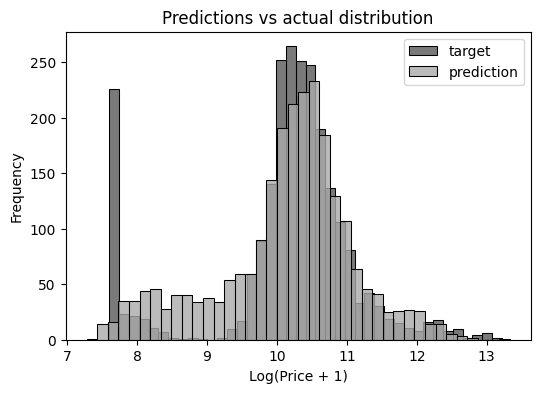

In [32]:
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

As observed, our model demonstrates a robust ability to predict car prices within the logarithmic scale range of $[10,13]$. This corresponds to a price range of $\$22,000$ to $\$440,000$. Let's apply our model to predict car prices:

In [33]:
# to select the features of the test data
df_test.iloc[4]

make                                toyota
model                                venza
year                                  2013
engine_fuel_type          regular_unleaded
engine_hp                            268.0
engine_cylinders                       6.0
transmission_type                automatic
driven_wheels              all_wheel_drive
number_of_doors                        4.0
market_category      crossover,performance
vehicle_size                       midsize
vehicle_style                        wagon
highway_mpg                             25
city_mpg                                18
popularity                            2031
Name: 11270, dtype: object

In [34]:
i = 4
criteria = df_test.iloc[i].to_dict()
criteria

X_test = prepare_X(pd.DataFrame([criteria]))[0]
y_pred = w_0 + X_test.dot(w)
# exponential because we take the log(x+1) before
price_suggestion = np.expm1(y_pred)

printest("Suggested price",price_suggestion)
printest("Suggested price",y_test_orig[i])


Suggested price : 
 28299.495500572044 

Suggested price : 
 31120 



 Looking at the results, it's clear that our model's predictions match closely with the actual price of the chosen car, based on the parameters we set. The predicted prices fall within the $\$22,000$ to $\$440,000$ range. This demonstrates the model's ability to effectively generalize and predict prices within this range for unseen data. 